In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import sparse
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from sklearn.utils import shuffle
import sys

my_filepath = "/Users/kinichen/UTSSRP/Tuzhilina_Project/UTSSRP-github/contact_dict.pkl"

In [2]:
if __name__ == "__main__":	# don't run if imported
	# load data nested dictionary data file 
	# Format contact_dict = {cell_type: {cell_name: dataframe, ...}, ...}
	# E.g. {'GM12878': {'cell1.txt': contact_matrix1, 'cell2.txt': contact_matrix2},
	#     'K562': {'cell3.txt': contact_matrix3}, ...}
	with open(my_filepath, "rb") as f:
		contact_dict = pickle.load(f)

	# display(contact_dict)

In [3]:
def vectorize_contact_matrix(contact_matrix, include_diag=False):
	"""
	Vectorizes the block-diagonal contact matrix using the upper triangle.
	
	Args:
		contact_matrix (ndarray): Square 4D block matrix of shape (chr_i, chr_j, loc_i, loc_j).
		include_diagonal (bool): Whether to include the diagonal in the vector.
	
	Returns:
		1D np.array of concatenated vectorized intra-chromosome contacts.
	"""
	vectorized = []

	for i in range(23):  # for each chromosome (diagonal block)
	# note: assuming no INTER-chromosomal contact blocks
		block = np.array(contact_matrix[i][i])
		length = block.shape[0]  # number of loci

		k = 1 # Default is exclude diagonal
		if include_diag:
			k = 0
		triu_indices = np.triu_indices(length, k=k)
		upper_triangle = block[triu_indices]

		vectorized.append(upper_triangle)
		

	# concatenate all chromosomes into one vector in row-major style
	return np.concatenate(vectorized)



In [4]:
def get_X_labels_lens(contact_dict):
	"""
	Get overall matrix X for applying dimension reduction
	rows = number of cells (observations), 
	columns = number of contact intersections/"pixels" (features)

	Output: X (np array): (num_cells, num_features)
		cell_labels (list of tuples): (cell_type, cell_name) for each row = cell in X
		labels (list): type of each cell
		chr_lens (list): length (number of loci) for each chromosome
	"""
	# Master matrix and labels
	all_vectors = []
	cell_labels = []
	labels = []
	chr_lens = []

	first_cell = True
	for cell_type, cells in contact_dict.items():
		for cell_name, matrix in cells.items():
			vec = vectorize_contact_matrix(matrix)
			all_vectors.append(vec)
			cell_labels.append((cell_type, cell_name))
			labels.append(cell_type)	# for coloring cell points by their type
			
			if first_cell: # only need to find chromosome lengths for one cell
				for i in range(23):  # for each chromosome (diagonal block)
					block = np.array(matrix[i][i])
					chr_lens.append(block.shape[0])
				first_cell = False

	# convert to np array for efficient masking. Else, kernel will crash
	labels = np.array(labels)
				
	# Stack into a matrix: each row is a vectorized cell
	X = np.vstack(all_vectors)
	return(X, cell_labels, labels, chr_lens)

if __name__ == "__main__":	# don't run if imported
	X, cell_labels, labels, chr_lens = get_X_labels_lens(contact_dict)
	print("X shape:", X.shape)	# UNfiltered: 2611 cell files, 236562 loci contact pairs
	# display(X)

X shape: (2611, 236562)


In [12]:
# Scatter biplot of PC1 vs PC2. Each point represents a cell coloured by its cell type.
def biplot(X_pca, loadings, labels=None, feature_names=None, top_features=5):
	plt.figure(figsize=(10, 5))

	if labels is not None: # labelling cells by type
		unique_labels = sorted(np.unique(labels))
		colors = plt.cm.get_cmap('tab10', len(unique_labels))
		for i, label in enumerate(unique_labels):
			mask = labels == label
			plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
						label=label, s=40, alpha=0.6, color=colors(i))
	else:
		plt.scatter(X_pca[:, 0], X_pca[:, 1], s=40, alpha=0.6, color="gray")


	if top_features > 0:
		# Arrows for top contributing feature vectors
		# norm for each feature row in loadings tells you how much that feature i
		# contributes to PC1 and PC2 aka how important that feature is!
		norms = np.linalg.norm(loadings[:, :2], axis=1)
		top_idx = np.argsort(norms)[-top_features:] # indices of the top features (largest norms)

		for i in top_idx:
			x, y = loadings[i, 0] * 2, loadings[i, 1] * 2
			name = feature_names[i] if feature_names else f"F{i}"
			plt.arrow(0, 0, x, y, color='crimson', alpha=0.7,
					head_width=0.04, head_length=0.08, linewidth=1.5)
			plt.text(x*1.1, y*1.1, name, color='crimson', fontsize=8)

	plt.gca().set_aspect('auto')  # default (PC1 and PC2 scaled independently)
	plt.xlabel("PC1")
	plt.ylabel("PC2")
	plt.title("PCA (Truncated SVD) Biplot with Top Features")
	if labels is not None:
		plt.legend()
	plt.grid(True)
	plt.show()


In [13]:
if __name__ == "__main__":
	# Check original X memory
	print("X shape:", X.shape)
	print("X dtype:", X.dtype)
	print("Approx. size of X (MB):", sys.getsizeof(X) / 1024**2)
	# super large total memory 2611 × 236562 × 4 bytes ≈ 2.36 GB

X shape: (2611, 236562)
X dtype: float32
Approx. size of X (MB): 2356.1989364624023


Explained variance ratio: [0.29110587 0.01174983]
X shape: (2611, 236562)
X_pca shape: (2611, 236562)
Loadings shape: (236562, 2)
Labels: {'GM12878', 'Hela', 'K562', 'HAP1'}


/var/folders/xp/t7rnpyzn1pbcbh0b7hnzp4dm0000gn/T/ipykernel_13677/90098829.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


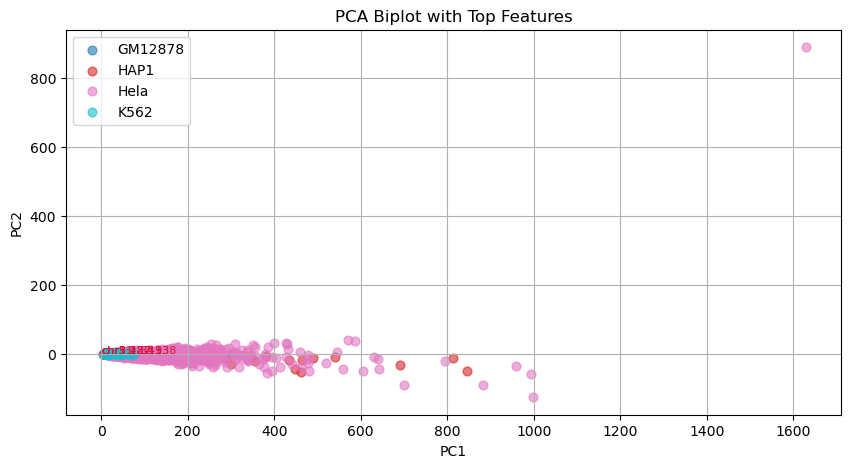

In [14]:
# For biplot visualization
if __name__ == "__main__":	# don't run if imported
	X = X.astype(np.float32) # halve memory space


	# To avoid kernel crashing again (data size is too large in memory for computation),
	# convert to sparse format (okay because X has many Os = no contact)
	X_sparse = sparse.csr_matrix(X)


	''' Alternative way to lower memory, but probably less representative of data
	# Subsample only less cells to avoid memory issues (kernel crashing again)
	X_small, labels_small = shuffle(X, labels, random_state=42) # seed for reproducibility
	# Note: not stratified sampling so not guaranteed representation for cell types with small sample sizes
	X_small = X_small[:300]
	labels_small = labels_small[:300]

	# Perform PCA, keeping only top 2 components
	X_scaled = StandardScaler().fit_transform(X)
	pca = PCA(n_components=2)
	X_pca = pca.fit_transform(X_scaled)
	'''

	# then perform PCA that supports sparse (i.e. TruncatedSVD)
	svd = TruncatedSVD(n_components=2)	# svd is much faster (no centering) but same idea as PCA
	X_pca = svd.fit_transform(X_sparse)

	loadings = svd.components_.T       # shape = (n_features, 2)
	explained_var = svd.explained_variance_ratio_
	print(f"Explained variance ratio: {svd.explained_variance_ratio_}")


	# Build feature_names, so can interpret key features from biplot
	# Each feature (column of X) represents a (chromosome, locus_i, locus_j) pair.
	# E.g. feature_names[i] = "chr3:42-47" means the ith feature corresponds to the
	# contact between locus 42 and locus 47 on chromosome 3 (only intrachromosomal contacts)
	feature_names = []
	chromosomes = [f"chr{i+1}" for i in range(len(chr_lens))]

	k = 1 # set to 0 if want to include block diagonals
	for chr_idx, chr_len in enumerate(chr_lens):
		for i in range(chr_len):
			for j in range(i + k, chr_len):
				feature_names.append(f"{chromosomes[chr_idx]}:{i}-{j}")

		
	# check
	assert len(feature_names) == X.shape[1], "Mismatch: feature_names do not align with X columns"

	print("X shape:", X.shape)
	print("X_pca shape:", X.shape)
	print("Loadings shape:", loadings.shape)
	print("Labels:", set(labels))

	biplot(X_pca, loadings, labels=labels, feature_names=feature_names, top_features=5)

In [ ]:
if __name__ == "__main__":
	# Perform general PCA, keeping components such that var_explained % of the 
	# variance is explained
	var_explained=0.9
	X_scaled = StandardScaler.fit_transform(X)
	pca = PCA(n_components=var_explained)
	X_pca = pca.fit_transform(X_scaled)
	# print(pca.n_components_)

	# save memory version, approximating to less components
	svd = TruncatedSVD(n_components=100)	# svd is much faster (no centering) but same idea as PCA
	X_pca = svd.fit_transform(X_sparse)
	print(svd.explained_variance_ratio_)

In [4]:
if __name__ == "__main__":
	# Scree plot (to examine the lower rank structure of contact data)
	'''
	pca = PCA()
	X_pca_full = pca.fit_transform(X_scaled)
	explained_var = pca.explained_variance_ratio_
	'''

	# using sparse X and svd
	svd = TruncatedSVD(n_components=100)	
	X_pca = svd.fit_transform(X_sparse)
	explained_var = svd.explained_variance_ratio_
	print("Cumulative explained variance:", explained_var)


	plt.figure(figsize=(8, 5))
	plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', 
		  linestyle='-', label='Individual')
	plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var), 
		  marker='x', linestyle='--', label='Cumulative')
	plt.xlabel('Principal Component/Singular Vector')
	plt.ylabel('Explained Variance Ratio')
	plt.title('Scree Plot')
	plt.xticks(range(1, len(explained_var)+1))
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

NameError: name 'X_sparse' is not defined